In [132]:
from torchvision import datasets
train_dataset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True)
print(f"# of images (train): {len(train_dataset)}")
print(f"# of images (test): {len(test_dataset)}")
print(f"# of classes: {len(train_dataset.classes)}")
print(f"size of 1st image: {train_dataset[0][0].size}")

Files already downloaded and verified
Files already downloaded and verified
# of images (train): 50000
# of images (test): 10000
# of classes: 10
size of 1st image: (32, 32)


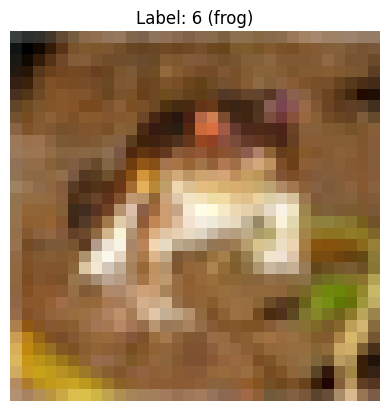

In [133]:
import matplotlib.pyplot as plt
image, label = train_dataset[0]
plt.imshow(image)
plt.title(f'Label: {label} ({train_dataset.classes[label]})')
plt.axis('off')
plt.show()

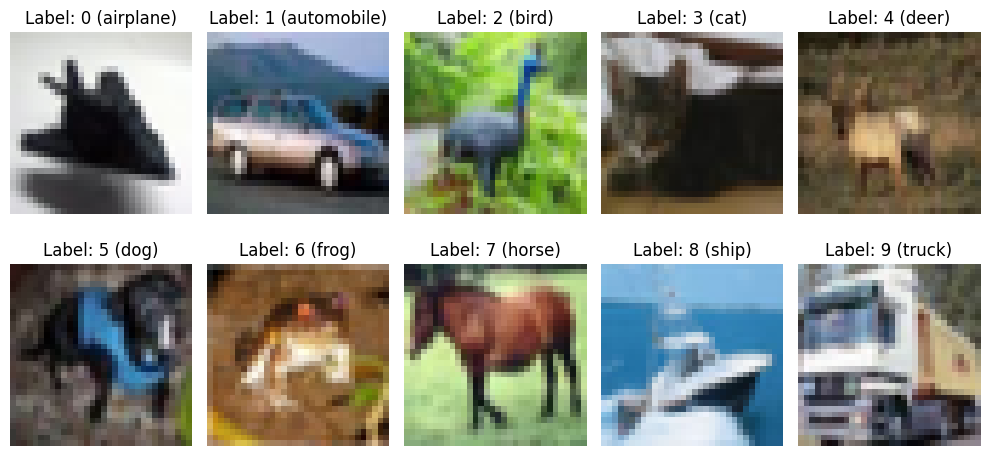

In [134]:
classes = train_dataset.classes
fig, axis = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    for image, label in train_dataset:
        if label == i:
            ax = axis[label // 5, label % 5]
            ax.imshow(image)
            ax.set_title(f"Label: {int(label)} ({classes[label]})")
            ax.axis('off')
            break
plt.tight_layout()
plt.show()

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [136]:
model = SimpleMLP()

In [137]:
from torchvision.transforms.functional import to_tensor
image, label = train_dataset[0]
sample = to_tensor(image).unsqueeze(0)
sample = (sample - 0.5) / 0.5

In [138]:
logits = model(sample)
probs = F.softmax(logits, dim=1)

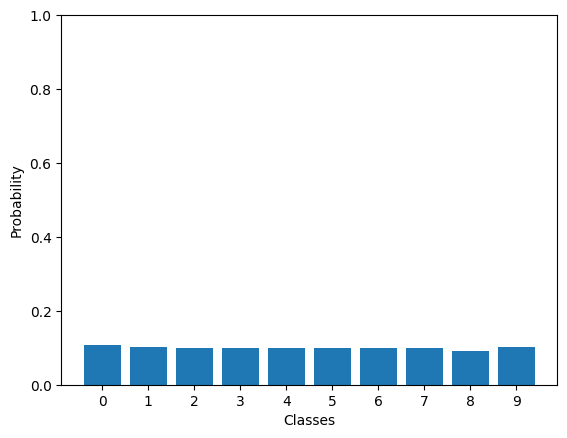

In [139]:
probs_np = probs.detach().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10))
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

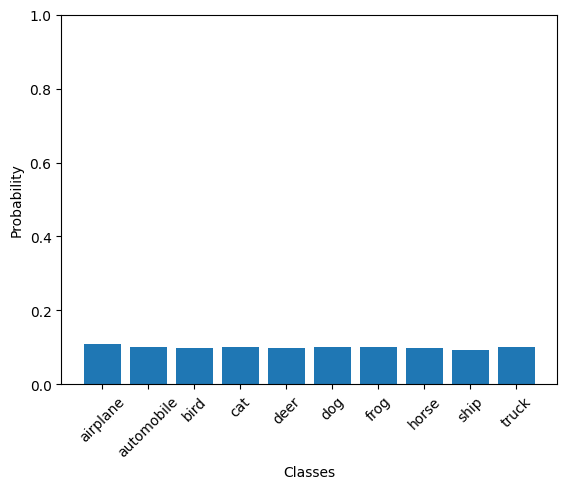

In [140]:
probs_np = probs.detach().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10), classes) # 変更
plt.xticks(rotation=45) # 変更
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

In [141]:
predicted_class = torch.argmax(probs, dim=1).item()
predicted_name = classes[predicted_class]
print(f"Predicted class: {predicted_class} ({predicted_name})")

Predicted class: 0 (airplane)


In [142]:
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
batch_size = 64
num_epochs = 5
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.CIFAR10(root='./CIFAR10', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [143]:
import torch.optim as optim

model = SimpleMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1/5: 100%|██████████| 782/782 [00:14<00:00, 55.82it/s]


Epoch 1, Loss: 1.6339


Epoch 2/5: 100%|██████████| 782/782 [00:22<00:00, 34.95it/s]


Epoch 2, Loss: 1.4299


Epoch 3/5: 100%|██████████| 782/782 [00:21<00:00, 35.72it/s]


Epoch 3, Loss: 1.3230


Epoch 4/5: 100%|██████████| 782/782 [00:21<00:00, 35.80it/s]


Epoch 4, Loss: 1.2284


Epoch 5/5: 100%|██████████| 782/782 [00:20<00:00, 37.87it/s]

Epoch 5, Loss: 1.1532


In [144]:
logits = model(sample)
probs = F.softmax(logits, dim=1)

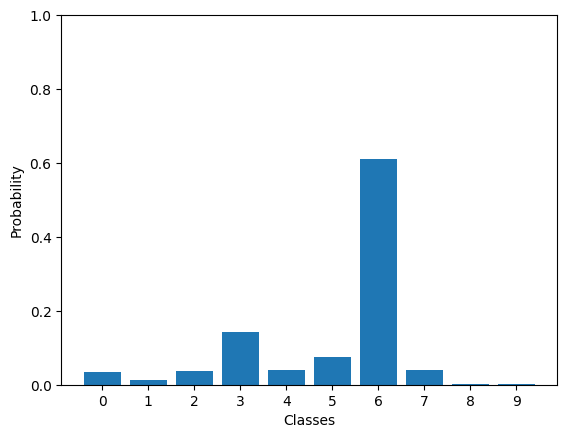

In [145]:
probs_np = probs.detach().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10))
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

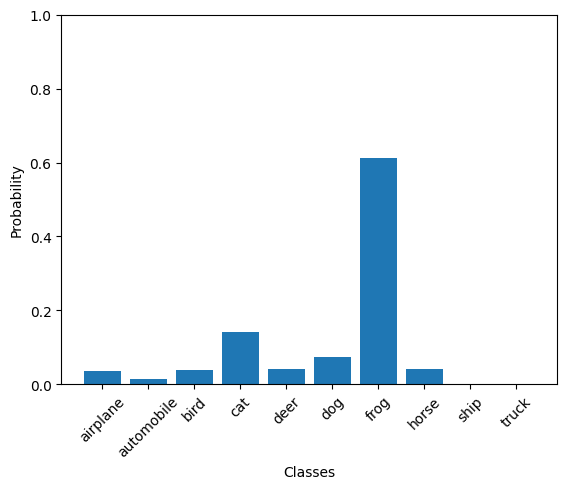

In [146]:
probs_np = probs.detach().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10), classes) # 変更
plt.xticks(rotation=45) # 変更
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

Files already downloaded and verified


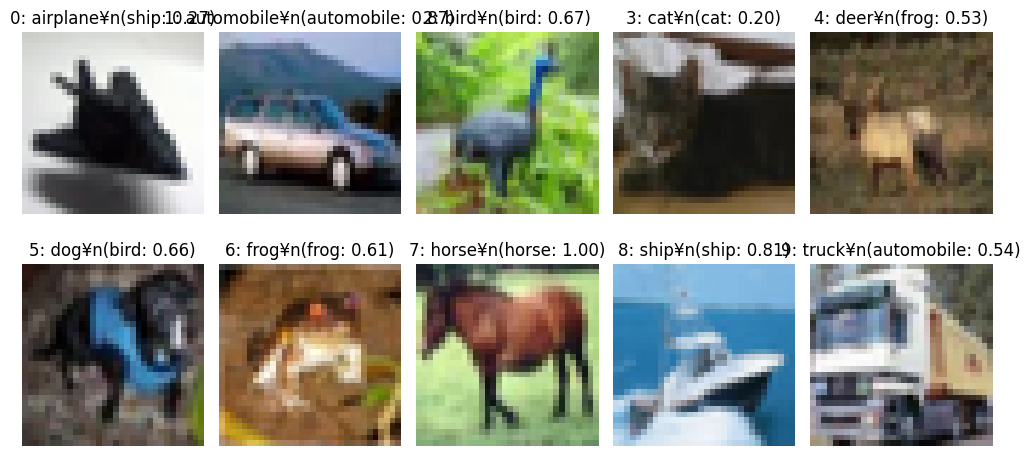

In [147]:
train_dataset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True)
model.eval()
fig, axis = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    for image, label in train_dataset:
        if label == i:
          logits = model(transform(image).unsqueeze(0))
          probs = F.softmax(logits, dim=1)
          predicted_label = torch.argmax(probs, dim=1).item()
          ax = axis[i // 5, i % 5]
          ax.imshow(image)
          ax.set_title(f'{label}: {classes[label]}¥n({classes[predicted_label]}: {probs[0][predicted_label]:.2f})')
          ax.axis('off')
          break
plt.tight_layout()
plt.show()

In [148]:
test_dataset = datasets.CIFAR10(root='./CIFAR10', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Files already downloaded and verified
Accuracy on test set: 52.21%


In [149]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(64 * 8 * 8, 512)
        self.linear2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [150]:
import torch.optim as optim
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1/5: 100%|██████████| 782/782 [00:26<00:00, 29.21it/s]


Epoch 1, Loss: 1.2764


Epoch 2/5: 100%|██████████| 782/782 [00:38<00:00, 20.41it/s]


Epoch 2, Loss: 0.8841


Epoch 3/5: 100%|██████████| 782/782 [00:38<00:00, 20.40it/s]


Epoch 3, Loss: 0.6981


Epoch 4/5: 100%|██████████| 782/782 [00:34<00:00, 22.50it/s]


Epoch 4, Loss: 0.5412


Epoch 5/5: 100%|██████████| 782/782 [00:36<00:00, 21.66it/s]

Epoch 5, Loss: 0.3906


In [151]:
logits = model(sample)
probs = F.softmax(logits, dim=1)

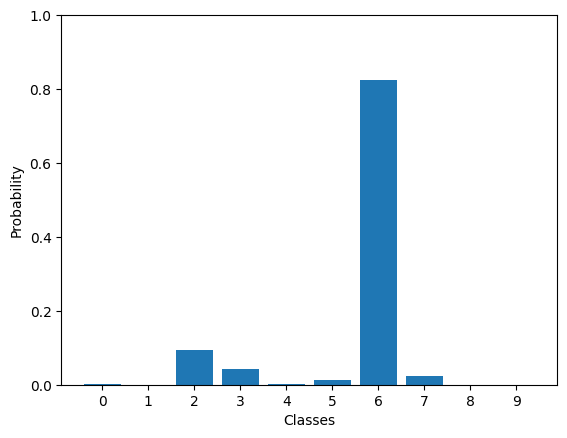

In [152]:
probs_np = probs.detach().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10))
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

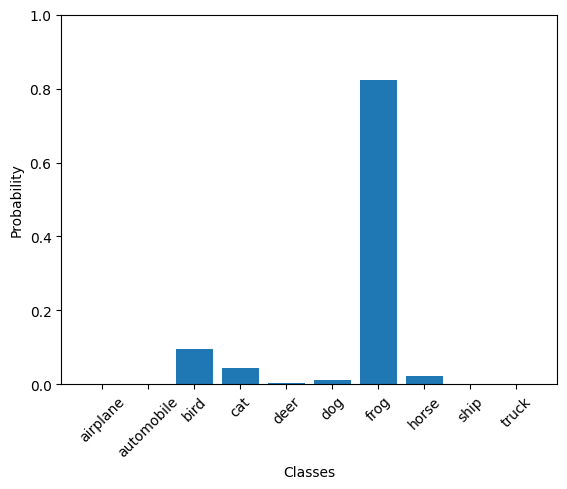

In [153]:
probs_np = probs.detach().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10), classes) # 変更
plt.xticks(rotation=45) # 変更
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

Files already downloaded and verified


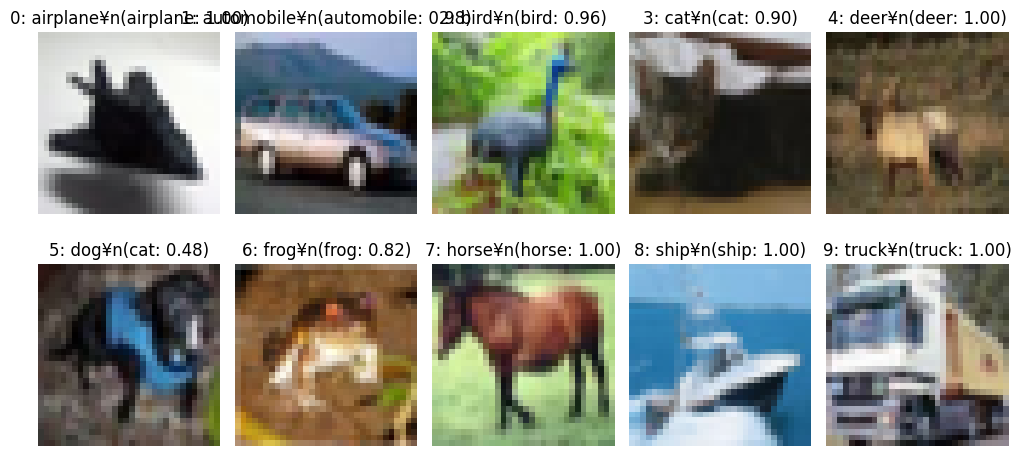

In [154]:
train_dataset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True)
model.eval()
fig, axis = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    for image, label in train_dataset:
        if label == i:
            logits = model(transform(image).unsqueeze(0))
            probs = F.softmax(logits, dim=1)
            predicted_label = torch.argmax(probs, dim=1).item()
            ax = axis[i // 5, i % 5]
            ax.imshow(image)
            ax.set_title(f'{label}: {classes[label]}¥n({classes[predicted_label]}: {probs[0][predicted_label]:.2f})')
            ax.axis('off')
            break
plt.tight_layout()
plt.show()

In [155]:
#ネットワークを普段のわかりやすい形に変更

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Linear(in_features=4*4*128, out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [156]:
#CPUでは計算が遅いのでGPUを使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [157]:
import torch.optim as optim
model = CNN()
model.to(device)
batch_size = 128
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1/10: 100%|██████████| 782/782 [00:12<00:00, 63.29it/s]


Epoch 1, Loss: 1.3481


Epoch 2/10: 100%|██████████| 782/782 [00:12<00:00, 61.17it/s]


Epoch 2, Loss: 0.8692


Epoch 3/10: 100%|██████████| 782/782 [00:14<00:00, 52.53it/s]


Epoch 3, Loss: 0.6620


Epoch 4/10: 100%|██████████| 782/782 [00:17<00:00, 45.11it/s]


Epoch 4, Loss: 0.5243


Epoch 5/10: 100%|██████████| 782/782 [00:18<00:00, 42.22it/s]


Epoch 5, Loss: 0.3992


Epoch 6/10: 100%|██████████| 782/782 [00:20<00:00, 37.74it/s]


Epoch 6, Loss: 0.3026


Epoch 7/10: 100%|██████████| 782/782 [00:16<00:00, 47.66it/s]


Epoch 7, Loss: 0.2280


Epoch 8/10: 100%|██████████| 782/782 [00:16<00:00, 47.62it/s]


Epoch 8, Loss: 0.1724


Epoch 9/10: 100%|██████████| 782/782 [00:18<00:00, 41.67it/s]


Epoch 9, Loss: 0.1458


Epoch 10/10: 100%|██████████| 782/782 [00:14<00:00, 53.29it/s]

Epoch 10, Loss: 0.1258


In [158]:
sample = sample.to(device)
logits = model(sample)
probs = F.softmax(logits, dim=1)

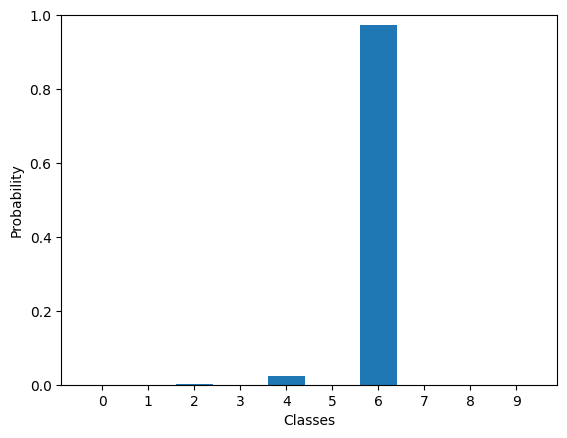

In [159]:
probs_np = probs.detach().cpu().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10))
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

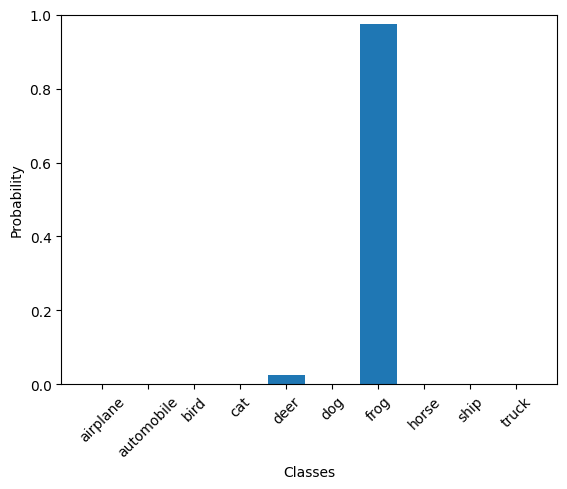

In [160]:
probs_np = probs.detach().cpu().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10), classes) # 変更
plt.xticks(rotation=45) # 変更
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

Files already downloaded and verified


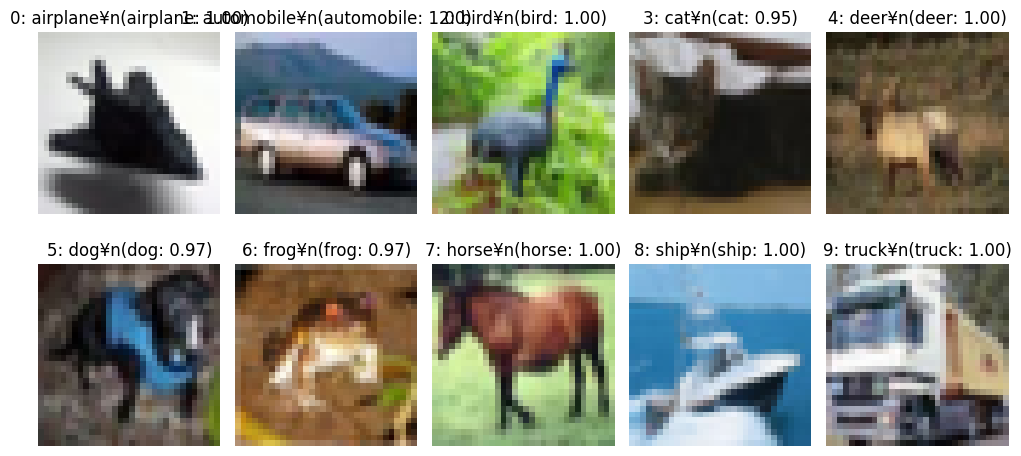

In [161]:
train_dataset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True)
model.cpu()
model.eval()
fig, axis = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    for image, label in train_dataset:
        if label == i:
            logits = model(transform(image).unsqueeze(0))
            probs = F.softmax(logits, dim=1)
            predicted_label = torch.argmax(probs, dim=1).item()
            ax = axis[i // 5, i % 5]
            ax.imshow(image)
            ax.set_title(f'{label}: {classes[label]}¥n({classes[predicted_label]}: {probs[0][predicted_label]:.2f})')
            ax.axis('off')
            break
plt.tight_layout()
plt.show()